In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
from bs4 import BeautifulSoup
import json
import numpy as np

In [2]:
with open("/content/drive/MyDrive/Sarcasm-Detector/Sarcasm.json",'r') as input:
  data = json.load(input)
print(len(data))

26709


In [3]:
## Use NLTK's Stopword List
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
sarcasm_sentences = []
labels = []
links = []
punctuations = str.maketrans('', '', string.punctuation)
for item in data:
  sentence = item['headline'].lower()
  sentence = sentence.replace(",", " , ").replace(".", " . ").replace("-", " - ").replace("/", " / ")
  sentence = BeautifulSoup(sentence, "html.parser").get_text()

  words = sentence.split()
  filtered_sentence = ""

  for word in words:
    word = word.translate(punctuations)
    if word not in stopwords:
      filtered_sentence += word + " "
  sarcasm_sentences.append(filtered_sentence)
  labels.append(item['is_sarcastic'])
  links.append(item['article_link'])

In [5]:
print(len(sarcasm_sentences))

26709


In [6]:
training_size = 24000
vocab_size = 20000
maxlen = 40
training_sentences = sarcasm_sentences[0:training_size]
training_labels = labels[0:training_size]
testing_sentences = sarcasm_sentences[training_size:]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequence, maxlen=maxlen, padding='post', truncating='post')
testing_sequence = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequence, maxlen=maxlen, padding='post', truncating='post')

In [8]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels).astype(np.float32).reshape(-1)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels).astype(np.float32).reshape(-1)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',   # You can also monitor 'val_accuracy'
    patience=8,           # Stop after 10 epochs of no improvement
    restore_best_weights=True
)


In [10]:
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(input_dim=20000, output_dim=16, input_length=maxlen),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )
model.build(input_shape=(None, maxlen))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 16)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,633 (1.39 MB)

 Trainable params: 365,633 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stop],
                    batch_size=32
                  )

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6891 - loss: 0.5643 - val_accuracy: 0.8154 - val_loss: 0.3991
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9075 - loss: 0.2270 - val_accuracy: 0.8191 - val_loss: 0.4210
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9590 - loss: 0.1142 - val_accuracy: 0.8154 - val_loss: 0.5149
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9797 - loss: 0.0586 - val_accuracy: 0.8088 - val_loss: 0.6126
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9825 - loss: 0.0703 - val_accuracy: 0.7970 - val_loss: 0.7264
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9892 - loss: 0.0334 - val_accuracy: 0.7929 - val_loss: 0.8570
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9943 - loss: 0.0162 - val_accuracy: 0.7992 - val_loss: 1.0569
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9968 - loss: 0.0096 - val_accu

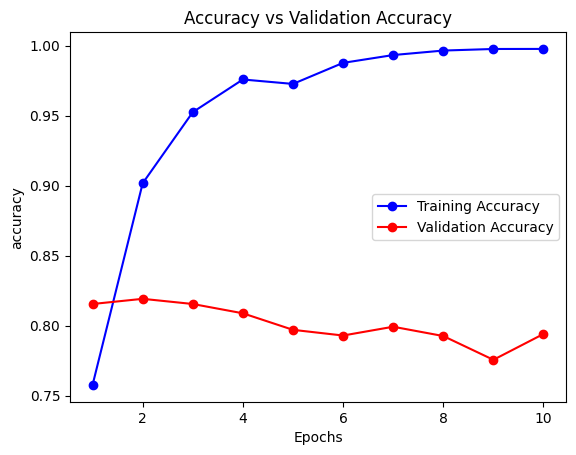

In [12]:
## plotting accuracy vs validation accuracy
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
  plt.title("Accuracy vs Validation Accuracy")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.show()
plot_accuracy(history)

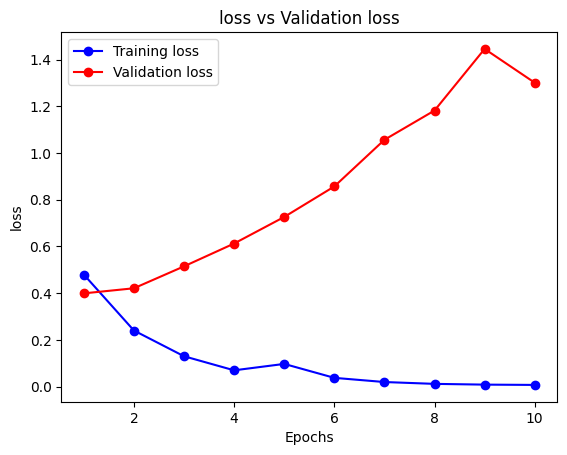

In [13]:
## plotting loss vs validation loss
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['loss']
  val_accuracy = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training loss')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation loss')
  plt.title("loss vs Validation loss")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.show()
plot_accuracy(history)

## Reducing Overfitting in Language Models

In [14]:
from tensorflow.keras.optimizers import Adam

model = tf.keras.Sequential([

          ## Exploring embedding dimensions
          tf.keras.layers.Embedding(vocab_size, 16),
          tf.keras.layers.SpatialDropout1D(0.3),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
          tf.keras.layers.GlobalAveragePooling1D(),

          ## Using regularization
          tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

          ## Using Dropout
          tf.keras.layers.Dropout(.3),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])

## Adjusting the learning rate
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.00003,beta_1=0.90, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )
history = model.fit(
    training_padded, training_labels,
    epochs=30,
    validation_data=(testing_padded, testing_labels),
    callbacks=[early_stop],
    batch_size=32
)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5651 - loss: 1.1644 - val_accuracy: 0.5748 - val_loss: 1.0464
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5591 - loss: 1.0198 - val_accuracy: 0.5748 - val_loss: 0.9347
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5603 - loss: 0.9163 - val_accuracy: 0.5748 - val_loss: 0.8527
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5630 - loss: 0.8397 - val_accuracy: 0.5748 - val_loss: 0.7802
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6583 - loss: 0.7239 - val_accuracy: 0.7409 - val_loss: 0.6224
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7758 - loss: 0.5774 - val_accuracy: 0.7612 - val_loss: 0.5798
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8024 - loss: 0.5203 - val_accuracy: 0.7763 - val_loss: 0.5409
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8224 - loss: 0.4748 - val_acc

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
preds = (model.predict(testing_padded) > 0.5).astype("int32")
print(confusion_matrix(testing_labels, preds))
print(classification_report(testing_labels, preds))

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[[1351  206]
 [ 325  827]]
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84      1557
         1.0       0.80      0.72      0.76      1152

    accuracy                           0.80      2709
   macro avg       0.80      0.79      0.80      2709
weighted avg       0.80      0.80      0.80      2709



## Making Prediction

In [27]:
sarcastic_sentences = [
    "Oclinton becomes first president to clear 18 feet in pole vault",
    "I love when my phone dies in the middle of a call—super convenient.",
    "Wow, you finally showed up. Only took you all day.",
    "Of course I studied for the test—I just enjoy failing.",
    "Nothing beats working all weekend. So relaxing!",
    "Yeah, because binge-watching Netflix all night was a great life decision.",
    "I totally wanted to spill coffee on my white shirt today.",
    "Sure, I *meant* to send that embarrassing text to my boss.",
    "Perfect! The internet went down right when I started my assignment."
]

In [28]:
sequences1 = tokenizer.texts_to_sequences(sarcastic_sentences)
padded1 = pad_sequences(sequences1, maxlen=maxlen, padding="post", truncating="post")
print("sarcastic_sentences Prediction")

print(model.predict(padded1))

sarcastic_sentences Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.87120175]
 [0.634019  ]
 [0.51548237]
 [0.89531595]
 [0.9364917 ]
 [0.78005755]
 [0.946525  ]
 [0.89960504]
 [0.3542234 ]]


In [29]:
non_sarcastic_sentences = [
    "He completed the assignment before the deadline.",
    "I like how this app helps me stay organized.",
    "They are planning a trip to New York next month.",
    "I’m learning how to cook Italian food.",
    "She smiled when she saw the surprise gift."
]

In [30]:
sequences2 = tokenizer.texts_to_sequences(non_sarcastic_sentences)
padded2 = pad_sequences(sequences2, maxlen=maxlen, padding="post", truncating="post")
print("non_sarcastic_sentences Prediction")
print(model.predict(padded2))

non_sarcastic_sentences Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.2441308 ]
 [0.086239  ]
 [0.7675101 ]
 [0.2552045 ]
 [0.38203108]]


In [31]:
from keras.saving import save_model
save_model(model, '/content/drive/MyDrive/Sarcasm-Detector/sarcasm.keras')